# Monte Carlo experiments

In this workbook, we develop some Monte Carlo experiments that illustrate different ways of estimating a share form multinomial logit. 

In the paper(!), we show that the log-likelihood function for a market $i$ can be written as follows, if $\phi$ is the normal density function:

$$
L_i = \Pi_{i=1}^N\frac{1}{\sigma}\phi\left(\frac{y-X\beta-\rho_i s_{i|g}}{\sigma}\right)\frac{1}{(1-\rho)^{N_g-1}}
$$

Accordingly, we can make moment conditions from the score function, or we can use this in estimation directly. We also have a proof that this can be written in the exponential form (do we?) 

In any event, we can put together a Monte-Carlo experiment.

To get started, let's get ipystata rolling, and then switch to the correct directory:

In [1]:
import ipystata

In [2]:
tempdir = 'C:\\Users\\mjbaker\\Documents\\github\\ShareFormNMNL'

In [3]:
%%stata -i tempdir 
cd "`tempdir'"


C:\Users\mjbaker\Documents\github\ShareFormNMNL



We will create a data set with 10000 observations over 1000 markets. Thus, each market will have ten competitors in it. We will also suppose that there are three nests. We can create market id's as follows (it's easiest to just use the mata kronecker delta to do this). 

The subsequent block of code then creates player ids, and then creates a grouping variable:

In [4]:
%%stata

clear all
set seed 5150
mata: mid = (1::1000)#J(10,1,1)
getmata mid

bysort mid: gen pid = _n

gen     group = 1
replace group = 2 if pid > 3 & pid < 7
replace group = 3 if pid > 6 & pid < 10
replace group = 0 if pid == 10

bysort mid group: egen N = count(pid)


(3,000 real changes made)

(3,000 real changes made)

(1,000 real changes made)



Let's next generate error terms and share terms and some group-level constants. Our outside alternative (group 0) has no error and just gives utility of one, so:

In [5]:
%%stata

gen e      = rnormal(0, 1)
gen mu     = 0
replace mu = -1 if group == 1
replace mu = -2 if group == 2
replace mu = -3 if group == 3

replace e = 0 if group == 0


(3,000 real changes made)

(3,000 real changes made)

(3,000 real changes made)

(1,000 real changes made)



We now can add in the nested MNL logit stuff, and we will start with a case in which there is only one grouping parameter. So, we have: 

In [6]:
%%stata

scalar rho = .5

gen eui = exp((mu + e)/(1 - rho))
bysort mid group: egen totaleui = total(eui)
gen swg = eui/totaleui

Now, generate group shares, where we have to add up across all the groups:

In [7]:
%%stata

bysort mid group: gen lg = _n == _N
replace totaleui = totaleui^(1 - rho)
bysort mid: egen sumoverg = total(lg*totaleui)
    
drop if group == 0

gen sg = totaleui / sumoverg
gen share = swg*sg



(9,000 real changes made)

(1,000 observations deleted)




    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
       share |      9,000    .0692578    .1168993   1.82e-06   .8724021

(bin=39, start=1.818e-06, width=.02236924)



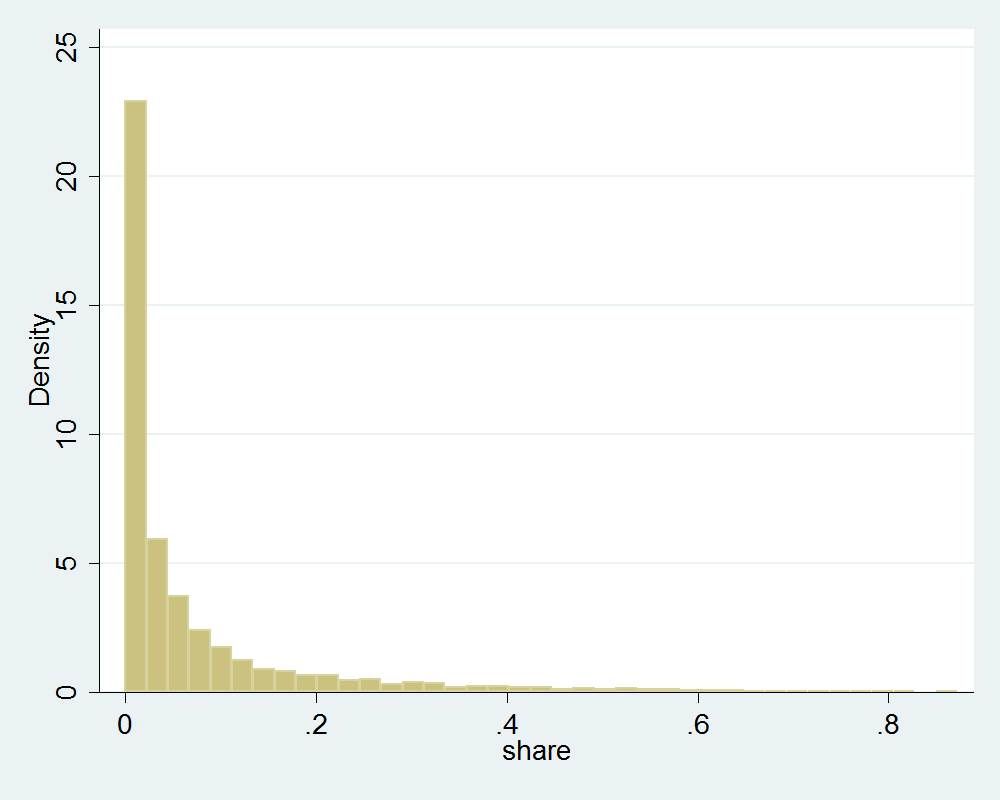

In [9]:
%%stata -gr

sum share

hist share

Now, some basic regression analysis:

In [12]:
%%stata 

bysort mid: egen ts = total(share)

gen s0 = 1 - ts
gen lns = ln(share) - ln(s0)
gen lnswg = ln(swg)

Basic grouping variables are as follows:

In [13]:
%%stata

gen g2 = group == 2
gen g3 = group == 3

## Linear Regression

Massively overstates things. 

In [15]:
%%stata 

reg lns lnswg g2 g3


      Source |       SS           df       MS      Number of obs   =     9,000
-------------+----------------------------------   F(3, 8996)      =  22408.23
       Model |  30730.9417         3  10243.6472   Prob > F        =    0.0000
    Residual |  4112.41032     8,996  .457137652   R-squared       =    0.8820
-------------+----------------------------------   Adj R-squared   =    0.8819
       Total |   34843.352     8,999  3.87191377   Root MSE        =    .67612

------------------------------------------------------------------------------
         lns |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       lnswg |   .9105205   .0039201   232.27   0.000     .9028362    .9182048
          g2 |  -1.033608   .0174583   -59.20   0.000     -1.06783   -.9993854
          g3 |  -2.021396   .0174574  -115.79   0.000    -2.055616   -1.987175
       _cons |  -.1531439   .0147306   -10.40   0.

## Maximimum Likelihood



In [18]:
%%stata

capture program drop mlfunbase
program mlfunbase
    version 14.1
    args lnf mu rho sigma
    quietly replace `lnf' = -($ML_y1 - `mu' - `rho'*$ML_y2)^2/(2*`sigma') - 1/2*ln(`sigma')  
    quietly replace `lnf' = `lnf' - ($ML_y3 - 1)*ln(1-`rho') if $ML_y4 == 1
end


  1.     version 14.1
  2.     args lnf mu rho sigma
  3.     quietly replace `lnf' = -($ML_y1 - `mu' - `rho'*$ML_y2)^2/(2*`sigma') - 1/2*ln(`sigma')  
  4.     quietly replace `lnf' = `lnf' - ($ML_y3 - 1)*ln(1-`rho') if $ML_y4 == 1
  5. end



In [19]:
%%stata 

ml model lf mlfunbase (mu: lns lnswg N lg = g2 g3) (rho:) (sigma:)
ml maximize


initial:       log likelihood =     -<inf>  (could not be evaluated)
feasible:      log likelihood = -64446.358
rescale:       log likelihood = -64446.358
rescale eq:    log likelihood = -2767.2033
Iteration 0:   log likelihood = -2767.2033  (not concave)
Iteration 1:   log likelihood =  7064.1097  (not concave)
Iteration 2:   log likelihood =  16300.699  (not concave)
Iteration 3:   log likelihood =  28563.171  (not concave)
Iteration 4:   log likelihood =  36910.434  (not concave)
Iteration 5:   log likelihood =   57006.18  (not concave)
Iteration 6:   log likelihood =  65289.446  (not concave)
Iteration 7:   log likelihood =  76903.545  (not concave)
Iteration 8:   log likelihood =  81155.142  (not concave)
Iteration 9:   log likelihood =  86526.996  (not concave)
Iteration 10:  log likelihood =   94913.21  (not concave)
Iteration 11:  log likelihood =  100503.31  (not concave)
Iteration 12:  log likelihood =  109563.08  (not concave)
Iteration 13:  log likelihood =  115774.75  (no